In [1]:
if 'google.colab' in str(get_ipython()):
    # Colab specific setup
    assignment_path = '/content/gdrive/My Drive/CIS680_2021/final_project/'
    
    # Mount your drive
    from google.colab import drive
    drive.mount("/content/gdrive")
    
    # Setup assignment folder and switch
    import os
    os.makedirs(assignment_path, exist_ok=True)
    os.chdir(assignment_path)
notebook_name = 'final_project.ipynb'

Mounted at /content/gdrive


In [ ]:
!unzip -q edges2shoes.zip

In [ ]:
!pip install visdom
!pip install line_profiler

In [27]:
from torch.utils import data
from PIL import Image
import numpy as np
import torch
import glob
import pdb
import warnings
warnings.filterwarnings("ignore")
from torch import nn, optim
import torch.nn.functional as F
from torchvision.models import resnet18
import torchvision.utils as vutils
import cv2
import plotly
from plotly.tools import mpl_to_plotly
%matplotlib inline
from matplotlib import pyplot as plt
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [28]:
class Edge2Shoe(data.Dataset):
	""" Dataloader for Edge2Shoe datasets 
		Note: we resize images (original 256x256) to 128x128 for faster training purpose 
		
		Args: 
			img_dir: path to the dataset

	"""
	def __init__(self, img_dir):
		image_list = []
		for img_file in glob.glob(str(img_dir)+'*'):
			image_list.append(img_file)
		self.image_list = image_list
		
	def __getitem__(self, index):
		image = Image.open(self.image_list[index]).resize((256,128), resample=Image.BILINEAR)
		image = np.asarray(image).transpose(2,0,1)
		image_tensor = torch.from_numpy(image).float()
		edge_tensor = image_tensor[:,:,:128]; rgb_tensor = image_tensor[:,:,128:]
		return edge_tensor, rgb_tensor

	def __len__(self):
		return len(self.image_list)


In [5]:
!ls

bicyclegan_20.pt   bicyclegan3_20.pt	bicyclegan4_20.pt  edges2shoes
bicyclegan2_20.pt  bicyclegan3_2_20.pt	bicyclegan5_20.pt  edges2shoes.zip


In [29]:
img_dir = './edges2shoes/train/' 
dataset = Edge2Shoe(img_dir)
loader = data.DataLoader(dataset, batch_size=16, num_workers=2)
test_img_dir = './edges2shoes/val/'
test_dataset = Edge2Shoe(test_img_dir)
test_loader = data.DataLoader(test_dataset, batch_size=1)
for idx, datat in enumerate(loader):
  edge_tensor, rgb_tensor = datat
  print(len(dataset), edge_tensor.shape, rgb_tensor.shape)
  break
for idx, datat in enumerate(test_loader):
  edge_tensor, rgb_tensor = datat
  print(len(test_dataset), edge_tensor.shape, rgb_tensor.shape)
  break

49825 torch.Size([16, 3, 128, 128]) torch.Size([16, 3, 128, 128])
200 torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])


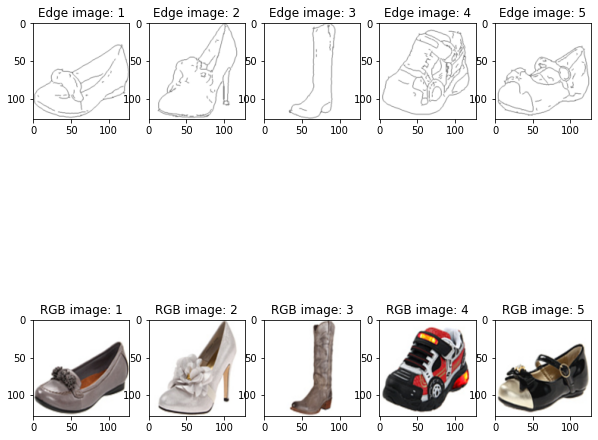

In [30]:
fig, axs = plt.subplots(2,5, figsize = (10,10))
for idx, datat in enumerate(loader):
  if (idx >= 5):
    break
  edge_tensor, rgb_tensor = datat
  axs[0,idx].imshow(edge_tensor.numpy().astype(np.uint8)[0,:,:,:].transpose(1,2,0))
  axs[0,idx].set_title("Edge image: "+str(idx+1))
  axs[1,idx].imshow(rgb_tensor.numpy().astype(np.uint8)[0,:,:,:].transpose(1,2,0))
  axs[1,idx].set_title("RGB image: "+str(idx+1))
plt.show()



In [23]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        """ The encoder used in both cVAE-GAN and cLR-GAN, which encode image B or B_hat to latent vector
            This encoder uses resnet-18 to extract features, and further encode them into a distribution
            similar to VAE encoder. 

            Note: You may either add "reparametrization trick" and "KL divergence" or in the train.py file
            
            Args in constructor: 
                latent_dim: latent dimension for z 
  
            Args in forward function: 
                img: image input (from domain B)

            Returns: 
                mu: mean of the latent code 
                logvar: sigma of the latent code 
        """

        # Extracts features at the last fully-connected
        resnet18_model = resnet18(pretrained=True)      
        self.feature_extractor = nn.Sequential(*list(resnet18_model.children())[:-3])
        self.pooling = nn.AvgPool2d(kernel_size=8, stride=8, padding=0)

        # Output is mu and log(var) for reparameterization trick used in VAEs
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def forward(self, img):
        out = self.feature_extractor(img)
        out = self.pooling(out)
        out = out.view(out.size(0), -1)
        mu = self.fc_mu(out)
        logvar = self.fc_logvar(out)
        return mu, logvar

In [64]:
class Generator(nn.Module):
    """ The generator used in both cVAE-GAN and cLR-GAN, which transform A to B
        
        Args in constructor: 
            latent_dim: latent dimension for z 
            image_shape: (channel, h, w), you may need this to specify the output dimension (optional)
        
        Args in forward function: 
            x: image input (from domain A)
            z: latent vector (encoded B)

        Returns: 
            fake_B: generated image in domain B
    """
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        channels, self.h, self.w = img_shape
        # (TODO: add layers...)
        # Using U-Net for the generator
        # First conv the channels to 16, retain dims
        self.start_layer = nn.Sequential(
                        nn.Conv2d(channels + latent_dim, 16, 3, padding=1),
                        nn.BatchNorm2d(16),
                        nn.LeakyReLU(0.2, inplace=True))
        # Next conv the channels to 32 half the dims to 64
        self.encode_layer1 = nn.Sequential(
                        nn.Conv2d(16, 32, 4, stride=2, padding=1),
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(0.2, inplace=True))
        # Next conv the channels to 64, half the dims, to 32
        self.encode_layer2 = nn.Sequential(
                        nn.Conv2d(32, 64, 4, stride=2, padding=1),
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(0.2, inplace=True))
        # Next conv the channels to 128, half the dims, to 16
        self.encode_layer3 = nn.Sequential(
                        nn.Conv2d(64, 128, 4, stride=2, padding=1),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(0.2, inplace=True))
        # Next conv the channels to 256, half the dims, to 8
        self.encode_layer4 = nn.Sequential(
                        nn.Conv2d(128, 256, 4, stride=2, padding=1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(0.2, inplace=True))
        # Next conv the channels to 512, half the dims, to 4
        self.encode_layer5 = nn.Sequential(
                        nn.Conv2d(256, 512, 4, stride=2, padding=1),
                        nn.BatchNorm2d(512),
                        nn.LeakyReLU(0.2, inplace=True))
        # Next Up-conv the channels to 16, double the dims to 128
        self.decode_up_layer1 = nn.Sequential(
                        nn.ConvTranspose2d(32, 16, 4,stride=2, padding=1),
                        nn.BatchNorm2d(16),
                        nn.LeakyReLU(0.2, inplace=True))
        # Next conv the concated output to 16 channels, retain dim
        self.decode_conc_layer1 = nn.Sequential(
                        nn.Conv2d(32, 16, 3, padding=1),
                        nn.BatchNorm2d(16),
                        nn.LeakyReLU(0.2, inplace=True))
        # Next Up-conv the channels to 32, double the dims to 64
        self.decode_up_layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64, 32, 4,stride=2, padding=1),
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(0.2, inplace=True))
        # Next conv the concated output to 32 channels, retain dim
        self.decode_conc_layer2 = nn.Sequential(
                        nn.Conv2d(64, 32, 3, padding=1),
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(0.2, inplace=True))
        # Next Up-conv the channels to 64, double the dims to 32
        self.decode_up_layer3 = nn.Sequential(
                        nn.ConvTranspose2d(128, 64, 4,stride=2, padding=1),
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(0.2, inplace=True))
        # Next conv the concated output to 64 channels, retain dim
        self.decode_conc_layer3 = nn.Sequential(
                        nn.Conv2d(128, 64, 3, padding=1),
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(0.2, inplace=True))
        # Next Up-conv the channels to 128, double the dims to 16
        self.decode_up_layer4 = nn.Sequential(
                        nn.ConvTranspose2d(256, 128, 4,stride=2, padding=1),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(0.2, inplace=True))
        # Next conv the concated output to 128 channels, retain dim
        self.decode_conc_layer4 = nn.Sequential(
                        nn.Conv2d(256, 128, 3, padding=1),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(0.2, inplace=True))
        # Next Up-conv the channels to 256, double the dims to 8
        self.decode_up_layer5 = nn.Sequential(
                        nn.ConvTranspose2d(512, 256, 4,stride=2, padding=1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(0.2, inplace=True))
        # Next conv the concated output to 256 channels, retain dim
        self.decode_conc_layer5 = nn.Sequential(
                        nn.Conv2d(512, 256, 3, padding=1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(0.2, inplace=True))
        # Final conv the channels to 3, retain dim
        self.final_layer = nn.Sequential(
                        nn.Conv2d(16, 3, 3, padding=1),
                        nn.Tanh())

    def forward(self, x, z):
        # (TODO: add layers...)
        z1 = z.unsqueeze(2).unsqueeze(2).repeat(1,1,self.h,self.w)
        # z1.requires_grad = False
        x1 = torch.cat([x,z1] ,dim=1)
        x1 = self.start_layer(x1)
        e1 = self.encode_layer1(x1)
        e2 = self.encode_layer2(e1)
        e3 = self.encode_layer3(e2)
        e4 = self.encode_layer4(e3)
        e5 = self.encode_layer5(e4)
        du5 = self.decode_up_layer5(e5)
        dc5 = torch.cat([du5,e4] ,dim=1)
        dc5 = self.decode_conc_layer5(dc5)
        du4 = self.decode_up_layer4(dc5)
        dc4 = torch.cat([du4,e3] ,dim=1)
        dc4 = self.decode_conc_layer4(dc4)
        du3 = self.decode_up_layer3(dc4)
        dc3 = torch.cat([du3,e2] ,dim=1)
        dc3 = self.decode_conc_layer3(dc3)
        du2 = self.decode_up_layer2(dc3)
        dc2 = torch.cat([du2,e1] ,dim=1)
        dc2 = self.decode_conc_layer2(dc2)
        du1 = self.decode_up_layer1(dc2)
        dc1 = torch.cat([du1,x1] ,dim=1)
        dc1 = self.decode_conc_layer1(dc1)
        x8 = self.final_layer(dc1)
        return x8

In [25]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        """ The discriminator used in both cVAE-GAN and cLR-GAN
            
            Args in constructor: 
                in_channels: number of channel in image (default: 3 for RGB)

            Args in forward function: 
                x: image input (real_B, fake_B)
 
            Returns: 
                discriminator output: could be a single value or a matrix depending on the type of GAN
        """
        self.layer =  nn.Sequential(
                        nn.Conv2d(in_channels, 32, 4, stride=2, padding=1),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),
                        nn.Conv2d(32, 64, 4,stride=2,padding=1),
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),
                        nn.Conv2d(64, 128, 4,stride=2,padding=1),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),
                        nn.Conv2d(128, 256, 4,stride=2,padding=1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),
                        nn.Conv2d(256, 512, 4,stride=2,padding=1),
                        nn.BatchNorm2d(512),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),
                        nn.Conv2d(512, 1, 4),
                        nn.Sigmoid())

    def forward(self, x):
        return self.layer(x)

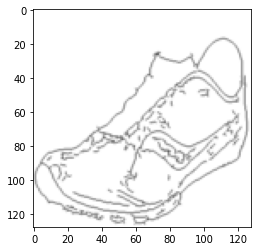

[ 0 / 20 ][ 0 / 3115 ]	Loss_D_clr:  5.557658672332764 	 5.559540748596191 	Loss_GE:  2599.8076171875 	 4716068.0 	 0.0042756181210279465 	 10.888006210327148 	 11.004464149475098


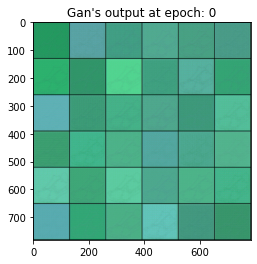

[ 0 / 20 ][ 150 / 3115 ]	Loss_D_clr:  5.531294822692871 	 5.5472092628479 	Loss_GE:  2704.08642578125 	 1204497.375 	 0.004341402091085911 	 11.089212417602539 	 11.162162780761719
[ 0 / 20 ][ 300 / 3115 ]	Loss_D_clr:  5.526795387268066 	 5.5282368659973145 	Loss_GE:  2687.261474609375 	 976324.9375 	 0.004313512239605188 	 11.316692352294922 	 11.382644653320312
[ 0 / 20 ][ 450 / 3115 ]	Loss_D_clr:  5.5158281326293945 	 5.523595809936523 	Loss_GE:  2593.234375 	 908771.375 	 0.004534525331109762 	 11.442096710205078 	 11.43794059753418
[ 0 / 20 ][ 600 / 3115 ]	Loss_D_clr:  5.515843391418457 	 5.526658058166504 	Loss_GE:  2388.406005859375 	 1127974.25 	 0.0045611620880663395 	 11.398151397705078 	 11.395233154296875
[ 0 / 20 ][ 750 / 3115 ]	Loss_D_clr:  5.5131378173828125 	 5.509011268615723 	Loss_GE:  2395.382080078125 	 1197297.375 	 0.004571882542222738 	 11.393718719482422 	 11.51980972290039
[ 0 / 20 ][ 900 / 3115 ]	Loss_D_clr:  5.5284743309021 	 5.511165618896484 	Loss_GE:  2473

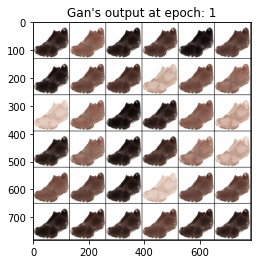

[ 1 / 20 ][ 150 / 3115 ]	Loss_D_clr:  5.417736053466797 	 5.293396472930908 	Loss_GE:  2519.20556640625 	 828032.8125 	 0.22150002419948578 	 12.217273712158203 	 11.684289932250977
[ 1 / 20 ][ 300 / 3115 ]	Loss_D_clr:  5.384187698364258 	 5.297634124755859 	Loss_GE:  2680.62890625 	 895323.8125 	 0.16820842027664185 	 12.150909423828125 	 12.275459289550781
[ 1 / 20 ][ 450 / 3115 ]	Loss_D_clr:  5.378498077392578 	 5.409492492675781 	Loss_GE:  2543.66650390625 	 557950.6875 	 0.23626677691936493 	 12.056625366210938 	 11.759725570678711
[ 1 / 20 ][ 600 / 3115 ]	Loss_D_clr:  5.2646565437316895 	 5.378814697265625 	Loss_GE:  2895.11962890625 	 596578.5625 	 0.2808113694190979 	 11.989748001098633 	 12.394432067871094
[ 1 / 20 ][ 750 / 3115 ]	Loss_D_clr:  5.363646984100342 	 5.317479133605957 	Loss_GE:  3179.576171875 	 821652.1875 	 0.2557019591331482 	 11.650617599487305 	 12.00413703918457
[ 1 / 20 ][ 900 / 3115 ]	Loss_D_clr:  5.4429779052734375 	 5.30535888671875 	Loss_GE:  2552.89697

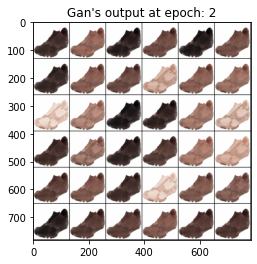

[ 2 / 20 ][ 150 / 3115 ]	Loss_D_clr:  5.045249938964844 	 4.725473403930664 	Loss_GE:  3290.09619140625 	 752462.6875 	 0.5013718008995056 	 14.443718910217285 	 13.24931812286377
[ 2 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.870559215545654 	 4.768537521362305 	Loss_GE:  3590.83203125 	 829604.625 	 0.38840192556381226 	 14.273319244384766 	 15.362321853637695
[ 2 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.946622371673584 	 5.138884544372559 	Loss_GE:  3638.0859375 	 494529.625 	 0.473784863948822 	 14.130043983459473 	 13.233652114868164
[ 2 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.743975639343262 	 5.042946815490723 	Loss_GE:  3059.698974609375 	 570296.625 	 0.5257840156555176 	 13.614288330078125 	 15.577674865722656
[ 2 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.839834213256836 	 4.8561553955078125 	Loss_GE:  3465.123046875 	 767329.25 	 0.47516849637031555 	 13.455848693847656 	 14.507621765136719
[ 2 / 20 ][ 900 / 3115 ]	Loss_D_clr:  5.21418571472168 	 4.836851119995117 	Loss_GE:  3195.1328125 	 556525

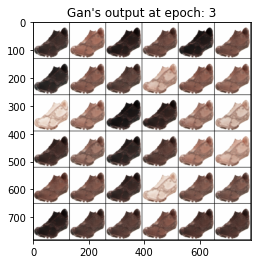

[ 3 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.581609725952148 	 4.340792655944824 	Loss_GE:  3439.5126953125 	 724856.5625 	 0.7723294496536255 	 17.117578506469727 	 16.496349334716797
[ 3 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.494662284851074 	 4.357801914215088 	Loss_GE:  3475.023681640625 	 885187.5625 	 0.5552956461906433 	 17.37942886352539 	 17.54789924621582
[ 3 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.566794395446777 	 4.873991966247559 	Loss_GE:  4107.46533203125 	 480237.90625 	 0.6909070611000061 	 16.2606201171875 	 15.213388442993164
[ 3 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.459120273590088 	 4.752537250518799 	Loss_GE:  4286.3603515625 	 600954.125 	 0.73441082239151 	 14.893491744995117 	 17.32086181640625
[ 3 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.478111743927002 	 4.509854316711426 	Loss_GE:  3280.90673828125 	 706330.875 	 0.6776071786880493 	 15.846352577209473 	 16.82617950439453
[ 3 / 20 ][ 900 / 3115 ]	Loss_D_clr:  4.843997955322266 	 4.462527275085449 	Loss_GE:  4232.96142578125 	

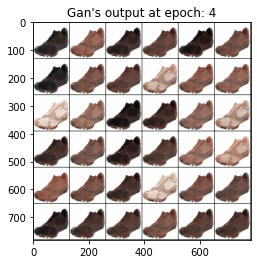

[ 4 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.366771697998047 	 4.144718170166016 	Loss_GE:  4136.12841796875 	 701490.6875 	 0.9821845889091492 	 19.761192321777344 	 17.815879821777344
[ 4 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.232224464416504 	 4.153369903564453 	Loss_GE:  4226.21728515625 	 796013.6875 	 0.6304562091827393 	 19.937641143798828 	 21.00777816772461
[ 4 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.448042392730713 	 4.685104846954346 	Loss_GE:  4065.262939453125 	 481237.46875 	 0.8717808127403259 	 17.929370880126953 	 15.616731643676758
[ 4 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.307914733886719 	 4.463653564453125 	Loss_GE:  4480.75341796875 	 591395.5625 	 0.9131560921669006 	 17.137020111083984 	 18.211572647094727
[ 4 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.209253311157227 	 4.294090270996094 	Loss_GE:  3722.2041015625 	 646578.1875 	 0.8485792279243469 	 18.162691116333008 	 20.547760009765625
[ 4 / 20 ][ 900 / 3115 ]	Loss_D_clr:  4.761549472808838 	 4.235561847686768 	Loss_GE:  4334.020

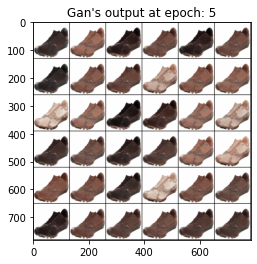

[ 5 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.20430326461792 	 4.0621137619018555 	Loss_GE:  3979.736328125 	 687456.9375 	 1.166616439819336 	 22.02730369567871 	 21.20779037475586
[ 5 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.106258392333984 	 4.053420066833496 	Loss_GE:  4298.31787109375 	 716445.0 	 0.6305632591247559 	 22.379302978515625 	 23.618488311767578
[ 5 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.21321964263916 	 4.532473087310791 	Loss_GE:  3898.04296875 	 446341.0 	 1.0238721370697021 	 19.769195556640625 	 18.807846069335938
[ 5 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.139715194702148 	 4.23551607131958 	Loss_GE:  4472.5439453125 	 493172.625 	 1.0810832977294922 	 20.672382354736328 	 22.113319396972656
[ 5 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.114192008972168 	 4.169111728668213 	Loss_GE:  4152.998046875 	 606499.6875 	 0.9842104315757751 	 20.09850311279297 	 22.393198013305664
[ 5 / 20 ][ 900 / 3115 ]	Loss_D_clr:  4.464524745941162 	 4.1267571449279785 	Loss_GE:  4305.2216796875 	 522285.343

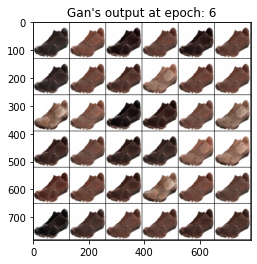

[ 6 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.0892333984375 	 4.040982246398926 	Loss_GE:  2892.531494140625 	 700541.1875 	 1.250939130783081 	 23.282808303833008 	 24.028553009033203
[ 6 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.050887107849121 	 4.022167205810547 	Loss_GE:  3095.5244140625 	 660490.1875 	 0.574723482131958 	 24.229501724243164 	 25.324071884155273
[ 6 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.145989418029785 	 4.414715766906738 	Loss_GE:  2951.94091796875 	 421364.59375 	 1.099847674369812 	 21.734264373779297 	 19.316049575805664
[ 6 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.056613445281982 	 4.155974388122559 	Loss_GE:  3917.435791015625 	 495289.0 	 1.1981619596481323 	 22.754005432128906 	 24.447031021118164
[ 6 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.107410430908203 	 4.104970932006836 	Loss_GE:  3059.12646484375 	 592509.75 	 1.1697570085525513 	 21.616127014160156 	 22.778030395507812
[ 6 / 20 ][ 900 / 3115 ]	Loss_D_clr:  4.251464366912842 	 4.078580856323242 	Loss_GE:  3100.7275390625 

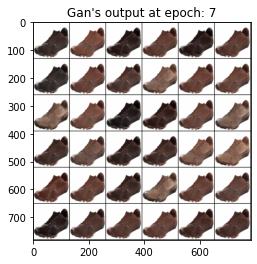

[ 7 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.064441204071045 	 4.022295951843262 	Loss_GE:  2612.867431640625 	 682279.25 	 1.3585784435272217 	 25.304889678955078 	 24.481233596801758
[ 7 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.025472640991211 	 4.020172119140625 	Loss_GE:  2911.9560546875 	 610737.875 	 0.5788832902908325 	 25.781982421875 	 26.15838623046875
[ 7 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.068840980529785 	 4.401668548583984 	Loss_GE:  3088.221435546875 	 404042.84375 	 1.150683879852295 	 23.435598373413086 	 22.386775970458984
[ 7 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.066500186920166 	 4.124258995056152 	Loss_GE:  2822.15673828125 	 496089.3125 	 1.3309338092803955 	 22.865291595458984 	 24.64032745361328
[ 7 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.060818672180176 	 4.10466194152832 	Loss_GE:  2867.19677734375 	 563929.6875 	 1.3068928718566895 	 20.763710021972656 	 24.90607261657715
[ 7 / 20 ][ 900 / 3115 ]	Loss_D_clr:  4.539426326751709 	 4.062875747680664 	Loss_GE:  3329.799560546875

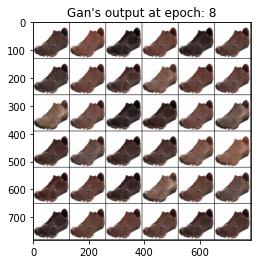

[ 8 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.05161190032959 	 4.035740852355957 	Loss_GE:  1993.783935546875 	 671683.125 	 1.3109211921691895 	 25.411075592041016 	 24.713623046875
[ 8 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.016670227050781 	 4.022489547729492 	Loss_GE:  3111.46826171875 	 621973.9375 	 0.6108593940734863 	 26.461076736450195 	 27.128440856933594
[ 8 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.124285697937012 	 4.385394096374512 	Loss_GE:  2874.49658203125 	 417575.75 	 1.1599466800689697 	 23.34345245361328 	 20.69713592529297
[ 8 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.037969589233398 	 4.172980308532715 	Loss_GE:  3291.224609375 	 464539.75 	 1.4231423139572144 	 22.14612579345703 	 25.08084487915039
[ 8 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.044230937957764 	 4.057778358459473 	Loss_GE:  2761.159423828125 	 533969.875 	 1.4236153364181519 	 22.702251434326172 	 24.806594848632812
[ 8 / 20 ][ 900 / 3115 ]	Loss_D_clr:  4.335084915161133 	 4.05781888961792 	Loss_GE:  3039.703369140625 	 453

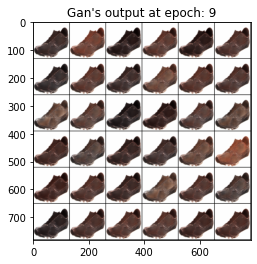

[ 9 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.045915126800537 	 4.053496360778809 	Loss_GE:  3005.004150390625 	 658140.8125 	 1.3340444564819336 	 24.12371826171875 	 25.03000259399414
[ 9 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.014871120452881 	 4.026615142822266 	Loss_GE:  3073.814453125 	 616661.8125 	 0.645912230014801 	 26.7127685546875 	 27.002037048339844
[ 9 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.040182113647461 	 4.473492622375488 	Loss_GE:  3103.47412109375 	 398043.78125 	 1.2209757566452026 	 23.094783782958984 	 25.214378356933594
[ 9 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.03045654296875 	 4.176797389984131 	Loss_GE:  3162.699951171875 	 477704.75 	 1.474104881286621 	 22.882394790649414 	 26.369861602783203
[ 9 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.044441223144531 	 4.186885833740234 	Loss_GE:  2500.994873046875 	 534198.5 	 1.4720226526260376 	 18.593420028686523 	 24.915555953979492
[ 9 / 20 ][ 900 / 3115 ]	Loss_D_clr:  4.162405014038086 	 4.095015525817871 	Loss_GE:  2902.2392578125 	 

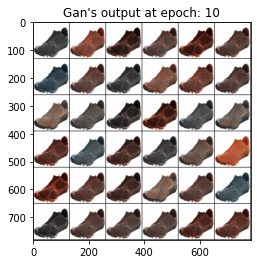

[ 10 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.067167282104492 	 4.230250358581543 	Loss_GE:  3103.587158203125 	 609702.875 	 1.3020381927490234 	 18.075477600097656 	 25.465648651123047
[ 10 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.023594856262207 	 4.563828468322754 	Loss_GE:  2771.78857421875 	 557980.1875 	 0.7063961029052734 	 13.183940887451172 	 25.799222946166992
[ 10 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.051260948181152 	 5.741456508636475 	Loss_GE:  2857.781982421875 	 388430.71875 	 1.2344722747802734 	 21.819900512695312 	 23.749160766601562
[ 10 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.0577850341796875 	 4.815282821655273 	Loss_GE:  2679.996337890625 	 451989.03125 	 1.3807750940322876 	 21.51628875732422 	 24.50033950805664
[ 10 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.04533576965332 	 4.07987642288208 	Loss_GE:  2613.756591796875 	 468877.4375 	 1.4702258110046387 	 22.383033752441406 	 25.386396408081055
[ 10 / 20 ][ 900 / 3115 ]	Loss_D_clr:  4.156720161437988 	 4.633190155029297 	Loss_GE:  

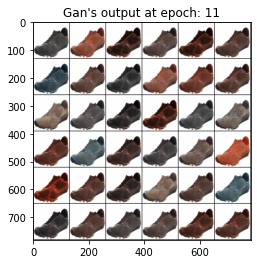

[ 11 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.044912338256836 	 4.055510997772217 	Loss_GE:  2785.839111328125 	 598546.125 	 1.4135138988494873 	 24.31023406982422 	 26.08236312866211
[ 11 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.028234481811523 	 4.394325256347656 	Loss_GE:  2886.57421875 	 526356.6875 	 0.8319059610366821 	 14.973978996276855 	 28.105981826782227
[ 11 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.903815269470215 	 5.595809459686279 	Loss_GE:  2806.56103515625 	 384113.78125 	 1.2646350860595703 	 22.016387939453125 	 10.736011505126953
[ 11 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.03366756439209 	 4.981302261352539 	Loss_GE:  2916.34619140625 	 417781.21875 	 1.4484015703201294 	 24.66364288330078 	 24.186338424682617
[ 11 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.06744384765625 	 4.108358383178711 	Loss_GE:  2683.41162109375 	 447495.84375 	 1.5247819423675537 	 20.863811492919922 	 23.265064239501953
[ 11 / 20 ][ 900 / 3115 ]	Loss_D_clr:  4.201898097991943 	 4.7966718673706055 	Loss_GE:  3330.4

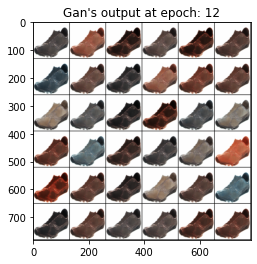

[ 12 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.062368869781494 	 4.088992118835449 	Loss_GE:  2901.999755859375 	 584165.25 	 1.5333025455474854 	 22.06545066833496 	 24.097652435302734
[ 12 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.02801513671875 	 4.274432182312012 	Loss_GE:  3072.7080078125 	 490846.0625 	 0.9252177476882935 	 16.267480850219727 	 27.707212448120117
[ 12 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.027888774871826 	 5.457003593444824 	Loss_GE:  2753.095947265625 	 381724.9375 	 1.357114553451538 	 18.983497619628906 	 26.162744522094727
[ 12 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.04477596282959 	 4.892666816711426 	Loss_GE:  3171.899658203125 	 396363.375 	 1.4667483568191528 	 22.815139770507812 	 24.03424072265625
[ 12 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.040444374084473 	 4.153027534484863 	Loss_GE:  3355.322998046875 	 414103.75 	 1.6301512718200684 	 19.575244903564453 	 26.05512237548828
[ 12 / 20 ][ 900 / 3115 ]	Loss_D_clr:  4.995978832244873 	 4.956755638122559 	Loss_GE:  3197.34497

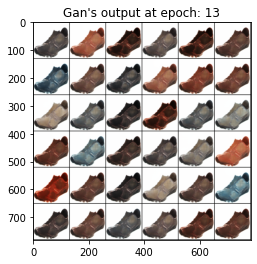

[ 13 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.097297668457031 	 4.047957420349121 	Loss_GE:  3666.25634765625 	 533245.75 	 1.5271050930023193 	 26.093265533447266 	 21.84156608581543
[ 13 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.0363616943359375 	 4.483546733856201 	Loss_GE:  3034.69384765625 	 510134.40625 	 1.0289607048034668 	 13.750423431396484 	 24.9211368560791
[ 13 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.029758453369141 	 5.241893768310547 	Loss_GE:  3492.00390625 	 384805.5625 	 1.3694108724594116 	 19.335906982421875 	 24.365093231201172
[ 13 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.045953750610352 	 4.774621963500977 	Loss_GE:  3248.0244140625 	 415468.8125 	 1.522221326828003 	 24.532424926757812 	 23.770593643188477
[ 13 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.064716339111328 	 4.237949371337891 	Loss_GE:  2776.08056640625 	 391394.0 	 1.657565712928772 	 17.284442901611328 	 24.186870574951172
[ 13 / 20 ][ 900 / 3115 ]	Loss_D_clr:  4.160427570343018 	 5.057337284088135 	Loss_GE:  2475.444335937

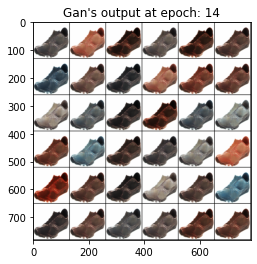

[ 14 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.0770158767700195 	 4.038762092590332 	Loss_GE:  2756.620361328125 	 535268.1875 	 1.5979911088943481 	 25.591522216796875 	 22.722835540771484
[ 14 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.036994457244873 	 4.429880619049072 	Loss_GE:  2899.447265625 	 472880.875 	 1.1055915355682373 	 14.37958812713623 	 27.235172271728516
[ 14 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.021329879760742 	 5.012494087219238 	Loss_GE:  3250.69189453125 	 355714.78125 	 1.454426646232605 	 21.959487915039062 	 24.760482788085938
[ 14 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.034154891967773 	 4.6878557205200195 	Loss_GE:  2813.294921875 	 408855.75 	 1.547788381576538 	 24.154321670532227 	 25.991111755371094
[ 14 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.964603900909424 	 4.1459126472473145 	Loss_GE:  2950.7109375 	 385027.03125 	 1.716989278793335 	 19.392786026000977 	 10.606605529785156
[ 14 / 20 ][ 900 / 3115 ]	Loss_D_clr:  4.274991512298584 	 5.135305404663086 	Loss_GE:  2940.507812

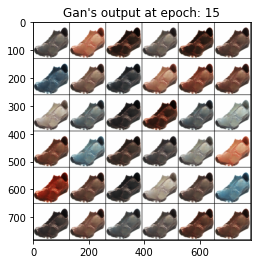

[ 15 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.317318916320801 	 4.02822208404541 	Loss_GE:  2662.82568359375 	 538392.0625 	 1.6621813774108887 	 25.766897201538086 	 15.92409896850586
[ 15 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.037871837615967 	 4.610932350158691 	Loss_GE:  2809.8017578125 	 434819.1875 	 1.1840002536773682 	 12.567252159118652 	 27.341218948364258
[ 15 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.152146339416504 	 4.8452606201171875 	Loss_GE:  3236.144287109375 	 348501.21875 	 1.5055460929870605 	 23.035680770874023 	 19.046852111816406
[ 15 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.046924114227295 	 4.643927574157715 	Loss_GE:  2856.2275390625 	 380823.53125 	 1.5888153314590454 	 23.418617248535156 	 23.374248504638672
[ 15 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.1079559326171875 	 4.188827037811279 	Loss_GE:  3307.93603515625 	 374543.34375 	 1.7997586727142334 	 18.45250701904297 	 26.143566131591797
[ 15 / 20 ][ 900 / 3115 ]	Loss_D_clr:  4.178041458129883 	 5.067042827606201 	Loss_GE:  3

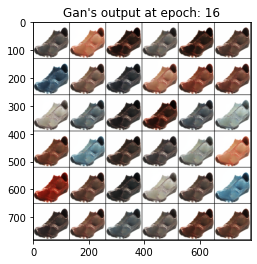

[ 16 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.0659003257751465 	 4.021126747131348 	Loss_GE:  3088.48681640625 	 536751.125 	 1.7159998416900635 	 26.410140991210938 	 26.359256744384766
[ 16 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.152919769287109 	 4.369380474090576 	Loss_GE:  3490.26171875 	 421084.25 	 1.2601609230041504 	 15.059426307678223 	 19.369033813476562
[ 16 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.1147990226745605 	 4.754534721374512 	Loss_GE:  2720.4169921875 	 358500.40625 	 1.5788317918777466 	 23.624696731567383 	 20.010860443115234
[ 16 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.119974136352539 	 4.628290176391602 	Loss_GE:  4011.008544921875 	 362724.0 	 1.678998351097107 	 22.254520416259766 	 20.041893005371094
[ 16 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.207418918609619 	 4.188000679016113 	Loss_GE:  2953.9521484375 	 357115.5625 	 1.8519877195358276 	 18.345441818237305 	 22.122920989990234
[ 16 / 20 ][ 900 / 3115 ]	Loss_D_clr:  4.283328056335449 	 5.129147052764893 	Loss_GE:  3481.63330

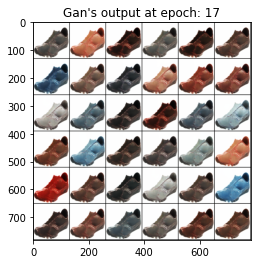

[ 17 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.075798988342285 	 4.0213470458984375 	Loss_GE:  2937.04541015625 	 541116.0625 	 1.7132586240768433 	 25.827669143676758 	 23.33767318725586
[ 17 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.148255348205566 	 4.6014251708984375 	Loss_GE:  3492.982421875 	 427490.375 	 1.3373748064041138 	 12.675872802734375 	 19.946483612060547
[ 17 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.707387924194336 	 4.736693859100342 	Loss_GE:  3257.9130859375 	 353414.90625 	 1.637643814086914 	 23.08397102355957 	 12.122674942016602
[ 17 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.03518533706665 	 4.605682373046875 	Loss_GE:  3489.42138671875 	 359703.71875 	 1.7160024642944336 	 23.806215286254883 	 26.619565963745117
[ 17 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.155181884765625 	 4.105743408203125 	Loss_GE:  3156.35107421875 	 364485.875 	 1.9204990863800049 	 20.638700485229492 	 26.877704620361328
[ 17 / 20 ][ 900 / 3115 ]	Loss_D_clr:  5.722170829772949 	 5.128175735473633 	Loss_GE:  3031.43

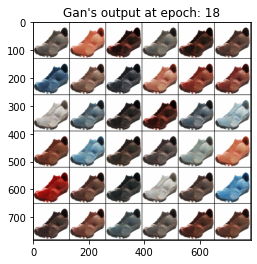

[ 18 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.093452453613281 	 4.0188703536987305 	Loss_GE:  3126.134033203125 	 517517.125 	 1.7706801891326904 	 25.82738494873047 	 26.046009063720703
[ 18 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.065884113311768 	 4.472912788391113 	Loss_GE:  3510.185302734375 	 411914.0 	 1.4197022914886475 	 13.908550262451172 	 24.68463134765625
[ 18 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.334576606750488 	 4.678714275360107 	Loss_GE:  2989.850341796875 	 342454.34375 	 1.676798939704895 	 25.341365814208984 	 15.983064651489258
[ 18 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.058437347412109 	 4.5515594482421875 	Loss_GE:  3871.213623046875 	 352590.46875 	 1.7395135164260864 	 24.143627166748047 	 23.39967918395996
[ 18 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.4262003898620605 	 4.244045257568359 	Loss_GE:  3271.8017578125 	 341445.1875 	 1.883591890335083 	 17.294864654541016 	 16.560100555419922
[ 18 / 20 ][ 900 / 3115 ]	Loss_D_clr:  4.946122169494629 	 5.065814018249512 	Loss_GE:  319

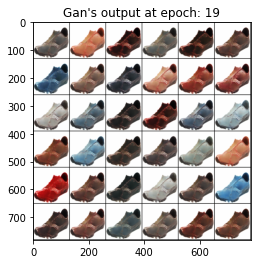

[ 19 / 20 ][ 150 / 3115 ]	Loss_D_clr:  4.066196918487549 	 4.020220756530762 	Loss_GE:  2689.7509765625 	 516839.1875 	 1.843645691871643 	 26.249387741088867 	 25.160242080688477
[ 19 / 20 ][ 300 / 3115 ]	Loss_D_clr:  4.083322525024414 	 4.217657566070557 	Loss_GE:  3248.66796875 	 393234.375 	 1.490808129310608 	 17.423507690429688 	 24.61884307861328
[ 19 / 20 ][ 450 / 3115 ]	Loss_D_clr:  4.197340965270996 	 4.633946895599365 	Loss_GE:  3026.88525390625 	 322841.0625 	 1.7239539623260498 	 25.51095962524414 	 19.278928756713867
[ 19 / 20 ][ 600 / 3115 ]	Loss_D_clr:  4.287094593048096 	 4.575598239898682 	Loss_GE:  2383.5712890625 	 349093.34375 	 1.758050799369812 	 22.03211212158203 	 16.427074432373047
[ 19 / 20 ][ 750 / 3115 ]	Loss_D_clr:  4.344282627105713 	 4.227471828460693 	Loss_GE:  3203.554443359375 	 335748.875 	 1.986814260482788 	 17.714452743530273 	 20.04147720336914
[ 19 / 20 ][ 900 / 3115 ]	Loss_D_clr:  5.784219741821289 	 5.113541126251221 	Loss_GE:  3319.595703125 

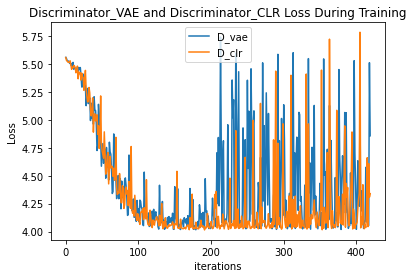

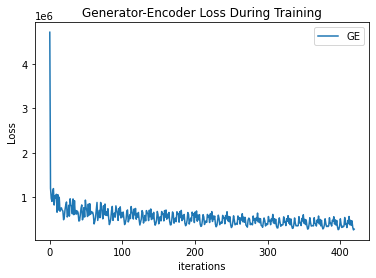

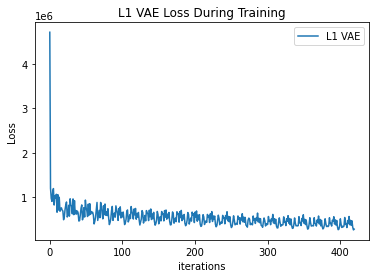

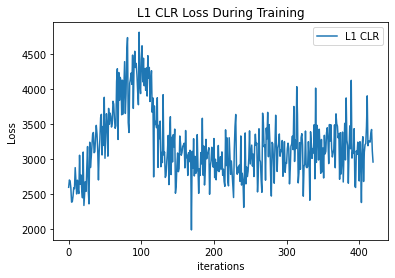

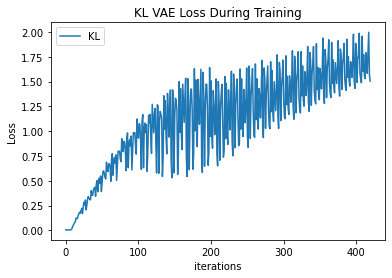

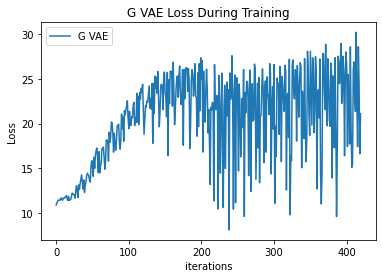

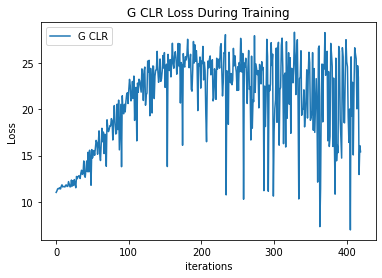

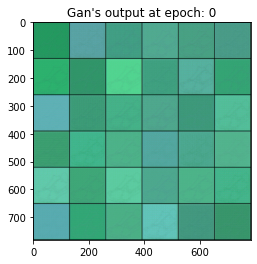

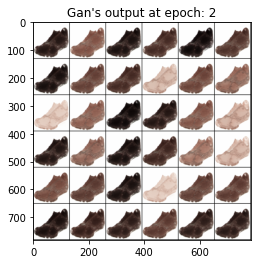

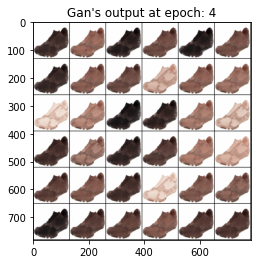

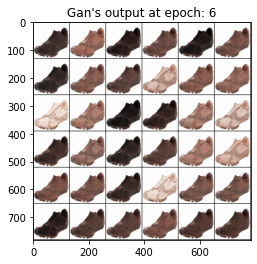

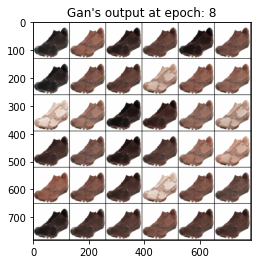

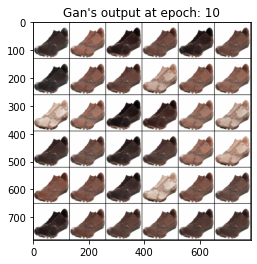

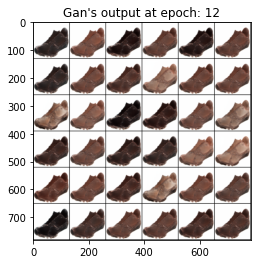

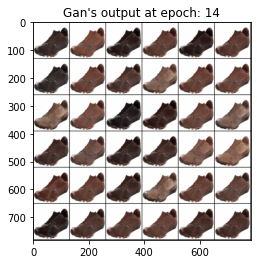

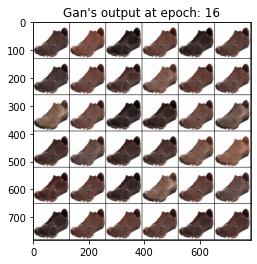

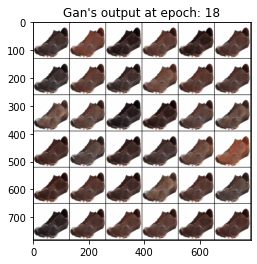

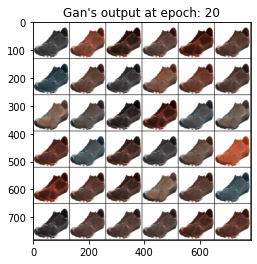

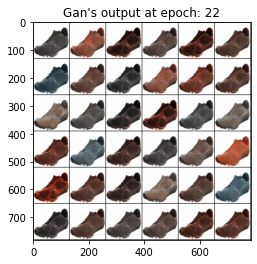

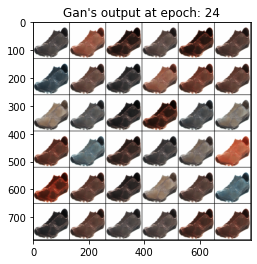

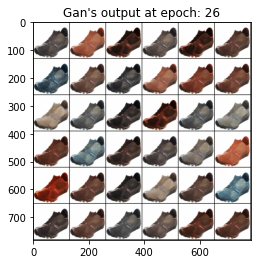

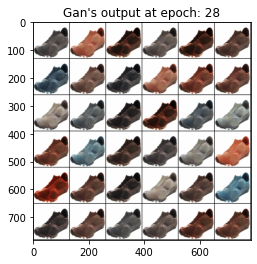

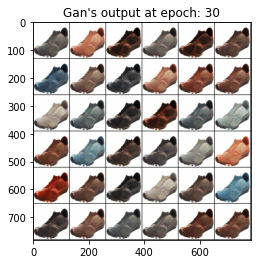

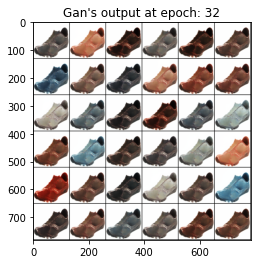

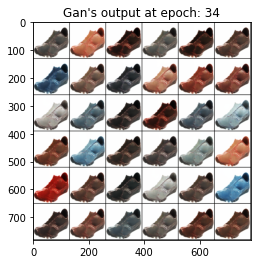

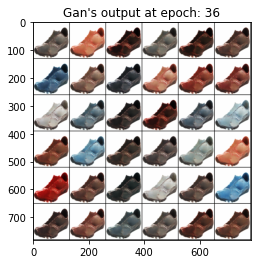

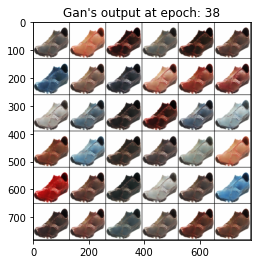

In [65]:
img_shape = (3, 128, 128)
latent_dim = 8
num_epochs = 20
batch_size = 16
lr_rate = 0.0002  	  # Adam optimizer learning rate
betas = (0.5, 0.999)  # Adam optimizer beta 1, beta 2
lambda_pixel = 15       # Loss weights for L1 image loss
lambda_latent = 50      # Loss weights for L1 latent regression
lambda_kl = 0.01          # Loss weights for kl divergence


# Normalize image tensor
def norm(image):
	return (image/255.0-0.5)*2.0

# Denormalize image tensor
def denorm(tensor):
	return ((tensor+1.0)/2.0)*255.0

# Reparameterization helper function
def reparameterization(mean, log_var):
    ################################
    # Please fill in std, eps and z:
    std = torch.exp(0.5 * log_var)
    eps = torch.normal(0,1,size=std.shape,device=std.device)
    z = mean + (std * eps)
    ################################

    return z

def init_weights(m):
  if isinstance(m, nn.Conv2d):
    nn.init.xavier_uniform(m.weight)
  elif isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight.data, 0.0, 0.02)
    nn.init.constant_(m.bias.data, 0.01)

def set_requires_grad(nets, requires_grad=False):
  for net in nets:
    if net is not None:
      for param in net.parameters():
        param.requires_grad = requires_grad

# Random seeds (optional)
torch.manual_seed(1); np.random.seed(1)
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Initialize networks
generator = Generator(latent_dim, img_shape).to(device)
encoder = Encoder(latent_dim).to(device)
D_VAE = Discriminator().to(device)
D_CLR = Discriminator().to(device)

# Initialize Weights for networks
generator.apply(init_weights)
D_VAE.apply(init_weights)
D_CLR.apply(init_weights)

# Define optimizers for networks
optimizer_E = torch.optim.Adam(encoder.parameters(), lr=lr_rate/40, betas=betas)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_rate*4, betas=betas)
optimizer_D_VAE = torch.optim.Adam(D_VAE.parameters(), lr=lr_rate/500, betas=betas)
optimizer_D_CLR = torch.optim.Adam(D_CLR.parameters(), lr=lr_rate/500, betas=betas)

# Losses for networks
L1_VAE_Loss = nn.L1Loss(reduction='sum')
L1_CRL_Loss = nn.L1Loss(reduction='sum')
Dis_loss = nn.BCELoss(reduction='sum')
def KLD_VAE_Loss(mu, log_var):
  std = torch.exp(log_var)
  KLD = torch.sum(std + torch.square(mu) - log_var - 1) / 2
  return KLD

# For adversarial loss (optional to use)
valid = 1; fake = 0
# Fixed input to test the performance of GAN
fixed_noise = torch.randn(36, latent_dim, device=device)
for test_idx, test_data in enumerate(test_loader):
  test_edge_tensor, test_rgb_tensor = test_data
  test_edge_tensor = test_edge_tensor.repeat(36,1,1,1)
  test_edge_tensor = norm(test_edge_tensor).to(device)
  example = denorm(test_edge_tensor[0,:,:,:]).cpu().numpy().astype(np.uint8)
  plt.imshow(np.transpose(example, (1, 2, 0)))
  plt.show()
  break

GE_losses = []
D_VAE_losses = []
D_CLR_losses = []
L1_VAE_losses = []
G_VAE_losses = []
G_CLR_losses = []
KL_VAE_losses = []
L1_CLR_losses = []
img_list = []
len_dataset = len(loader)

def func_f():
  for e in range(num_epochs):
    for idx, datat in enumerate(loader):
      edge_tensor, rgb_tensor = datat
      len_batch = edge_tensor.shape[0]
      len_data = len_batch // 2
      # Send the data to device
      edge_tensor, rgb_tensor = norm(edge_tensor).to(device), norm(rgb_tensor).to(device)
      # Split the data for vae and clr
      if (len_data == 0):
        real_A_vae = edge_tensor
        real_A_clr = edge_tensor
        real_B_vae = rgb_tensor
        real_B_clr = rgb_tensor
        Valid_label_vae = torch.full((1,1,1,1), valid, dtype=torch.float, device=device, requires_grad=False)
        Fake_label_vae = torch.full((1,1,1,1), fake, dtype=torch.float, device=device, requires_grad=False)
        Valid_label_clr = torch.full((1,1,1,1), valid, dtype=torch.float, device=device, requires_grad=False)
        Fake_label_clr = torch.full((1,1,1,1), fake, dtype=torch.float, device=device, requires_grad=False)
      else:
        real_A_vae = edge_tensor[0:len_data,:,:,:]
        real_A_clr = edge_tensor[len_data:,:,:,:]
        real_B_vae = rgb_tensor[0:len_data,:,:,:]
        real_B_clr = rgb_tensor[len_data:,:,:,:]
        Valid_label_vae = torch.full((len_data,1,1,1), valid, dtype=torch.float, device=device, requires_grad=False)
        Fake_label_vae = torch.full((len_data,1,1,1), fake, dtype=torch.float, device=device, requires_grad=False)
        Valid_label_clr = torch.full(((len_batch - len_data),1,1,1), valid, dtype=torch.float, device=device, requires_grad=False)
        Fake_label_clr = torch.full(((len_batch - len_data),1,1,1), fake, dtype=torch.float, device=device, requires_grad=False)

      #-------------------------------
      #  Train Generator and Encoder
      #------------------------------

      # Pass B through Encoder for VAE
      encoder_output_mean, encoder_output_logvar = encoder(real_B_vae)
      z = reparameterization(encoder_output_mean, encoder_output_logvar)
      # z = z.detach()
      # Get a random normal tensor for CLR
      z_clr = torch.randn(len_batch - len_data, latent_dim, device=device, requires_grad=False)
      # Generate fake B for VAE with A and z
      fake_B_vae = generator(real_A_vae, z)
      # Generate fake B for CLR with A and z_clr
      fake_B_clr = generator(real_A_clr, z_clr)
      # Pass fake B through Encoder
      fake_mu, fake_logvar = encoder(fake_B_clr)
      

      # Assign all the descriminator to not calculate gradients
      set_requires_grad([D_VAE, D_CLR], False)
      # Clear Optimizers
      optimizer_E.zero_grad()
      optimizer_G.zero_grad()
      # Calculate all the losses
      loss_L1_vae = L1_VAE_Loss(fake_B_vae, real_B_vae) * lambda_pixel
      loss_G_vae = Dis_loss(D_VAE(fake_B_vae), Valid_label_vae) * 2
      loss_G_clr = Dis_loss(D_CLR(fake_B_clr), Valid_label_clr) * 2
      loss_kl_vae = KLD_VAE_Loss(encoder_output_mean, encoder_output_logvar) * lambda_kl
      
      # Calculate the total loss
      total_loss = loss_G_vae + loss_G_clr + loss_kl_vae + loss_L1_vae
      # Backtrack it
      total_loss.backward(retain_graph=True)

      # Assign the encoder to not calculate gradients
      set_requires_grad([encoder], False)
      # Calculate loss for latent dim in CLR
      loss_L1_clr = L1_CRL_Loss(fake_mu, z_clr) * lambda_latent
      loss_L1_clr.backward()
      # Assign the encoder to again calculate gradients
      set_requires_grad([encoder], True)

      # Take a step for Optimizers
      optimizer_E.step()
      optimizer_G.step()

      # if (e % 3 == 0):
      #----------------------------------
      #  Train Discriminator (cVAE-GAN)
      #----------------------------------

      # Assign all the descriminator to not calculate gradients
      set_requires_grad([D_VAE, D_CLR], True)
      optimizer_D_VAE.zero_grad()
      # Calculate output for generated B (with detach from generator) and Real B
      pred_fake = D_VAE(fake_B_vae.detach())
      pred_real = D_VAE(real_B_vae)
      # Calculate Loss
      loss_D_vae_fake = Dis_loss(pred_fake, Fake_label_vae + 0.2)
      loss_D_vae_real = Dis_loss(pred_real, Valid_label_vae - 0.2)
      # Sum the losses and do backward
      loss_D_vae = (loss_D_vae_fake + loss_D_vae_real) / 2
      loss_D_vae.backward()
      # Take a step for Optimizer
      optimizer_D_VAE.step()
      
      #---------------------------------
      #  Train Discriminator (cLR-GAN)
      #---------------------------------

      optimizer_D_CLR.zero_grad()
      # Calculate output for generated B (with detach from generator) and Real B
      pred_fake_clr = D_CLR(fake_B_clr.detach())
      pred_real_clr = D_CLR(real_B_clr)
      # Calculate Loss
      loss_D_clr_fake = Dis_loss(pred_fake_clr, Fake_label_clr + 0.2)
      loss_D_clr_real = Dis_loss(pred_real_clr, Valid_label_clr - 0.2)
      # Sum the losses and do backward
      loss_D_clr = (loss_D_clr_fake + loss_D_clr_real) / 2
      loss_D_clr.backward()
      # Take a step for Optimizer
      optimizer_D_CLR.step()
      # else:
      #   loss_D_vae = torch.tensor(0)
      #   loss_D_clr = torch.tensor(0)


      # Save information
      if idx % 150 == 0:
        print("[",e,"/",num_epochs,"][",idx,"/",len_dataset,"]\tLoss_D_clr: ",loss_D_clr.item(),"\t",loss_D_vae.item(), "\tLoss_GE: ",loss_L1_clr.item(), "\t", loss_L1_vae.item(), "\t", loss_kl_vae.item(), "\t", loss_G_vae.item(), "\t", loss_G_clr.item())
        GE_losses.append(total_loss.item())
        D_VAE_losses.append(loss_D_vae.item())
        D_CLR_losses.append(loss_D_clr.item())
        L1_VAE_losses.append(loss_L1_vae.item())
        G_VAE_losses.append(loss_G_vae.item())
        G_CLR_losses.append(loss_G_clr.item())
        KL_VAE_losses.append(loss_kl_vae.item())
        L1_CLR_losses.append(loss_L1_clr.item())


      
      if ((e % 1 == 0) or (e == num_epochs-1)) and (idx == 0):
        with torch.no_grad():
          gen_output = generator(test_edge_tensor, fixed_noise)
        grid_gen_output = vutils.make_grid(denorm(gen_output), nrow=6, padding=2, normalize=True)
        img_list.append(grid_gen_output)
        plt.imshow(np.transpose(grid_gen_output.cpu().detach().numpy(), (1, 2, 0)))
        plt.title("Gan's output at epoch: " + str(e))
        plt.show()


      # if idx > 2:
      #   break

%lprun -f func_f func_f()

# Save Model
checkpoint = {'netG': generator.state_dict(),
              'netE': encoder.state_dict(),
              'netD1': D_VAE.state_dict(),
              'netD2': D_CLR.state_dict()}
torch.save(checkpoint, './bicyclegan8_{}.pt'.format(num_epochs))

# Display Discriminator losses
plt.title("Discriminator_VAE and Discriminator_CLR Loss During Training")
plt.plot(D_VAE_losses,label="D_vae")
plt.plot(D_CLR_losses,label="D_clr")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Display Total Generator-Encoder Losses
plt.title("Generator-Encoder Loss During Training")
plt.plot(GE_losses,label="GE")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Display L1 VAE Loss
plt.title("L1 VAE Loss During Training")
plt.plot(L1_VAE_losses,label="L1 VAE")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Display L1 CLR Loss
plt.title("L1 CLR Loss During Training")
plt.plot(L1_CLR_losses,label="L1 CLR")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Display KL VAE Loss
plt.title("KL VAE Loss During Training")
plt.plot(KL_VAE_losses,label="KL")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Display G VAE Loss
plt.title("G VAE Loss During Training")
plt.plot(G_VAE_losses,label="G VAE")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Display G CLR Loss
plt.title("G CLR Loss During Training")
plt.plot(G_CLR_losses,label="G CLR")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


for i,image_item in enumerate(img_list):
  plt.imshow(np.transpose(image_item.cpu().detach().numpy(), (1, 2, 0)))
  plt.title("Gan's output at epoch: " + str(2*i))
  plt.show()


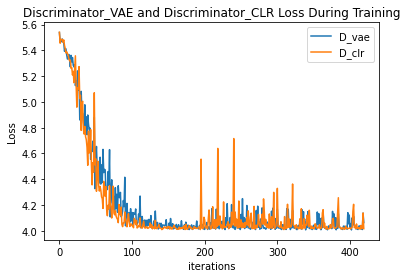

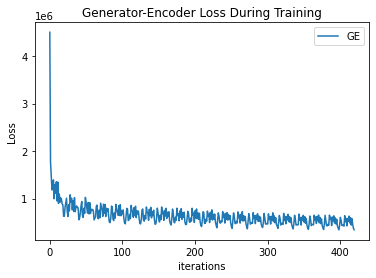

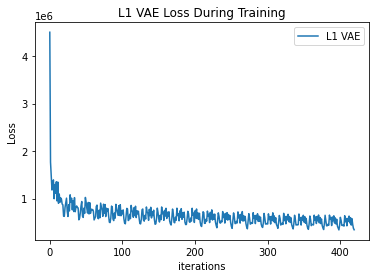

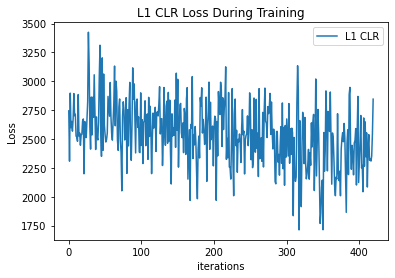

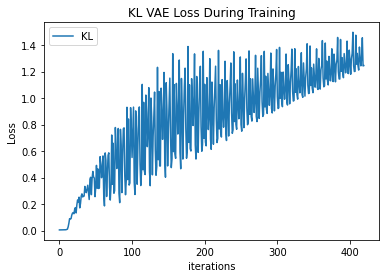

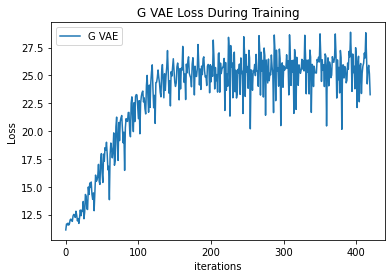

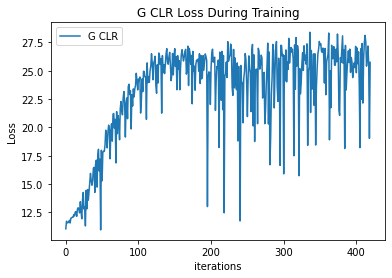

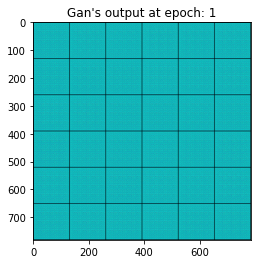

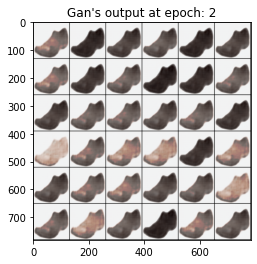

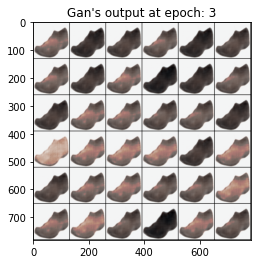

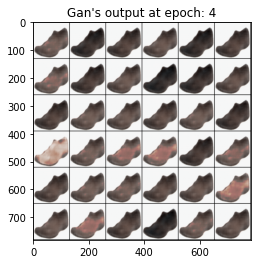

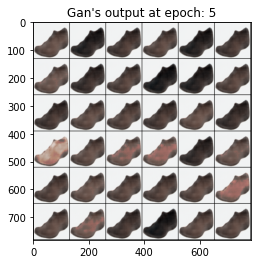

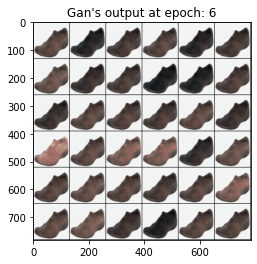

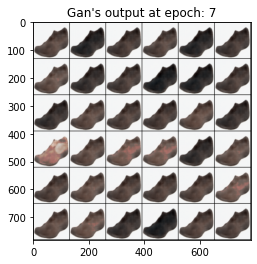

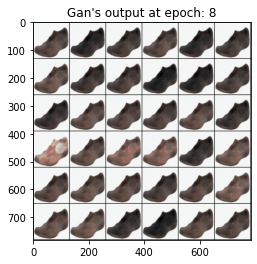

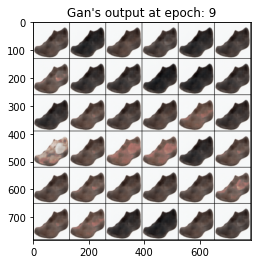

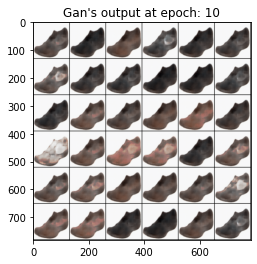

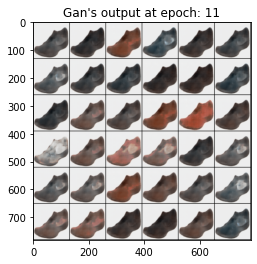

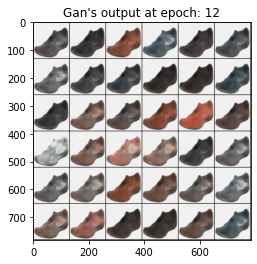

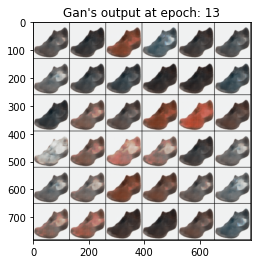

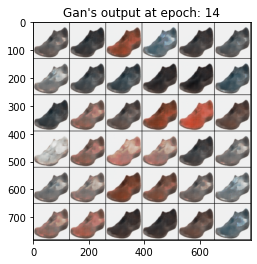

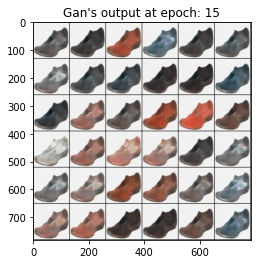

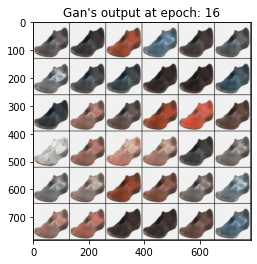

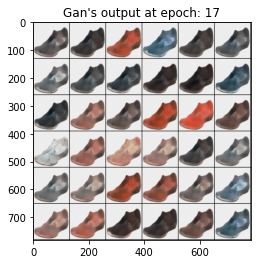

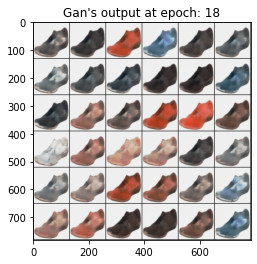

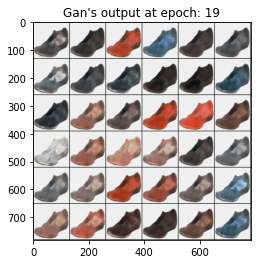

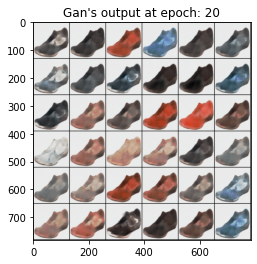

In [56]:
# Display Discriminator losses
plt.title("Discriminator_VAE and Discriminator_CLR Loss During Training")
plt.plot(D_VAE_losses,label="D_vae")
plt.plot(D_CLR_losses,label="D_clr")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Display Total Generator-Encoder Losses
plt.title("Generator-Encoder Loss During Training")
plt.plot(GE_losses,label="GE")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Display L1 VAE Loss
plt.title("L1 VAE Loss During Training")
plt.plot(L1_VAE_losses,label="L1 VAE")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Display L1 CLR Loss
plt.title("L1 CLR Loss During Training")
plt.plot(L1_CLR_losses,label="L1 CLR")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Display KL VAE Loss
plt.title("KL VAE Loss During Training")
plt.plot(KL_VAE_losses,label="KL")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Display G VAE Loss
plt.title("G VAE Loss During Training")
plt.plot(G_VAE_losses,label="G VAE")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
# Display G CLR Loss
plt.title("G CLR Loss During Training")
plt.plot(G_CLR_losses,label="G CLR")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
for i,image_item in enumerate(img_list):
  plt.imshow(np.transpose(image_item.cpu().detach().numpy(), (1, 2, 0)))
  plt.title("Gan's output at epoch: " + str(i+1))
  plt.show()

tensor(92.)


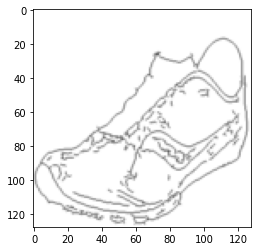

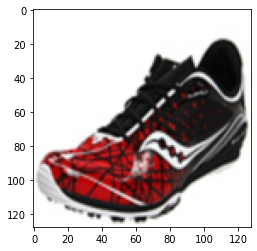

New Image


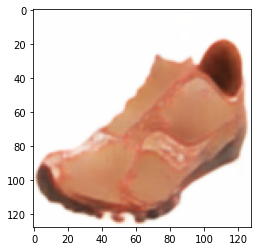

tensor(255., device='cuda:0')


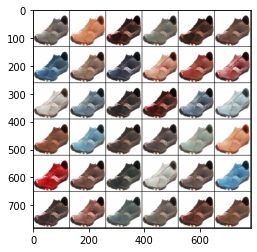

In [69]:
print(denorm(test_edge_tensor[0,:,:,:]).cpu().min())
plt.imshow(np.transpose(denorm(test_edge_tensor[0,:,:,:]).cpu().detach().numpy().astype(np.uint8), (1, 2, 0)))
plt.show()
plt.imshow(test_rgb_tensor[0,:,:,:].cpu().numpy().astype(np.uint8).transpose((1,2,0)))
plt.show()
with torch.no_grad():
  # encoder_output_mean, encoder_output_logvar = encoder(norm(test_rgb_tensor.to(device)))
  # z = reparameterization(encoder_output_mean, encoder_output_logvar)
  # print(z.shape)
  # print(test_edge_tensor.shape)
  print("New Image")
  new_z = torch.randn(1, latent_dim, device=device)
  gen_output = generator(test_edge_tensor[0,:,:,:].unsqueeze(0), new_z)
  plt.imshow(denorm(gen_output[0,:,:,:]).cpu().detach().numpy().astype(np.uint8).transpose((1,2,0)))
  plt.show()
  gen_output = generator(test_edge_tensor, fixed_noise)
  print(denorm(gen_output[0,:,:,:]).max())
  sq_out = vutils.make_grid(denorm(gen_output), nrow=6, padding=2, normalize=True)
  plt.imshow(np.transpose(sq_out.cpu().detach().numpy(), (1, 2, 0)))
  plt.show()

In [48]:
class Generator(nn.Module):
    """ The generator used in both cVAE-GAN and cLR-GAN, which transform A to B
        
        Args in constructor: 
            latent_dim: latent dimension for z 
            image_shape: (channel, h, w), you may need this to specify the output dimension (optional)
        
        Args in forward function: 
            x: image input (from domain A)
            z: latent vector (encoded B)

        Returns: 
            fake_B: generated image in domain B
    """
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        channels, self.h, self.w = img_shape
        # (TODO: add layers...)
        # Using U-Net for the generator
        # First conv the channels to 16, retain dims
        self.start_layer = nn.Sequential(
                        nn.Conv2d(channels + latent_dim, 32, 4, stride=2, padding=1),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.Conv2d(32, 64, 4, stride=2, padding=1),
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.Conv2d(64, 128, 4, stride=2, padding=1),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.Conv2d(128, 256, 4, stride=2, padding=1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.Conv2d(256, 512, 4, stride=2, padding=1),
                        nn.BatchNorm2d(512),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.ConvTranspose2d(512, 256, 4,stride=2, padding=1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.ConvTranspose2d(256, 128, 4,stride=2, padding=1),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.ConvTranspose2d(128, 64, 4,stride=2, padding=1),
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.ConvTranspose2d(64, 32, 4,stride=2, padding=1),
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.ConvTranspose2d(32, 3, 4,stride=2, padding=1),
                        nn.LeakyReLU(0.2, inplace=True))

    def forward(self, x, z):
        # (TODO: add layers...)
        z1 = z.unsqueeze(2).unsqueeze(2).repeat(1,1,self.h,self.w)
        # z1.requires_grad = False
        x1 = torch.cat([x,z1] ,dim=1)
        x2 = self.start_layer(x1)
        return x2

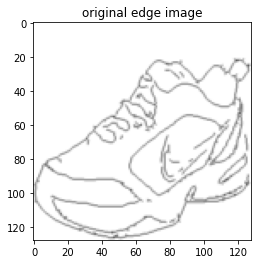

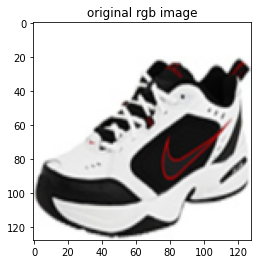

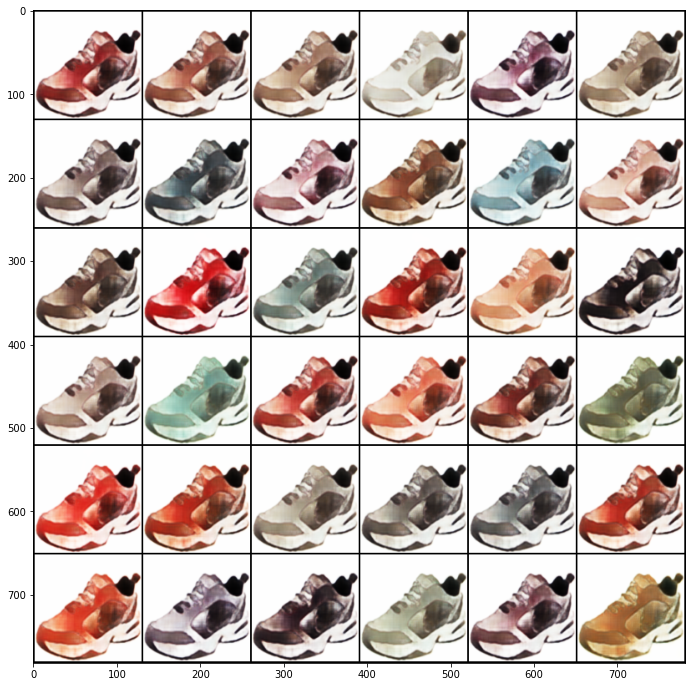

In [72]:
from torch.utils import data
from PIL import Image
import numpy as np
import torch
import glob
import pdb
import warnings
warnings.filterwarnings("ignore")
from torch import nn, optim
import torch.nn.functional as F
from torchvision.models import resnet18
import torchvision.utils as vutils
import cv2
import plotly
from plotly.tools import mpl_to_plotly
from matplotlib import pyplot as plt


# Normalize image tensor
def norm(image):
	return (image/255.0-0.5)*2.0

# Denormalize image tensor
def denorm(tensor):
	return ((tensor+1.0)/2.0)*255.0

# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(90); np.random.seed(90)
img_shape = (3, 128, 128)
img_dir = './edges2shoes/val/'
test_dataset = Edge2Shoe(test_img_dir)
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=True)
model_saved = torch.load('./bicyclegan8_20.pt')
test_generator = Generator(latent_dim, img_shape).to(device)
test_generator.load_state_dict(model_saved['netG'])
test_generator.eval()
fixed_noise = torch.randn(36, latent_dim, device=device)
for test_idx, test_data in enumerate(test_loader):
  test_edge_tensor, test_rgb_tensor = test_data
  test_edge_tensor = test_edge_tensor.repeat(36,1,1,1)
  test_edge_tensor = norm(test_edge_tensor).to(device)
  break

plt.imshow(np.transpose(denorm(test_edge_tensor[0,:,:,:]).cpu().detach().numpy().astype(np.uint8), (1, 2, 0)))
plt.title("original edge image")
plt.show()
plt.imshow(test_rgb_tensor[0,:,:,:].cpu().numpy().astype(np.uint8).transpose((1,2,0)))
plt.title("original rgb image")
plt.show()
with torch.no_grad():
    gen_output = test_generator(test_edge_tensor, fixed_noise)
    sq_out = vutils.make_grid(denorm(gen_output), nrow=6, padding=2, normalize=True)
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(sq_out.cpu().detach().numpy(), (1, 2, 0)))
    plt.show()
